<img src="logoD.png" alt="Logo MUII" align="right">

<br><br>
<a id="principio"></a> 

## Práctica 6

# Sistema híbrido de recomendación de películas


<br>
<div style="text-align: right">
Luis de la Ossa
<br>
Master Universitario en Ingeniería Informática
<br>
Universidad de Castilla-La Mancha

</div>

---

## 1. Introducción 

<br>
En esta práctica se elaborará un sencillo sistema de recomendación de películas. Para ello, se utilizará uno de los conjuntos de datos de [Movielens](https://grouplens.org/datasets/movielens/latest/), que ya fue introducido en la práctica cuatro, y que proporciona el "_genoma_" para aproximadamente de 11000 de ellas. Además, este conjunto de datos incluye información sobre votaciones hechas por más 270000 usuarios (26000000 de votos en total). 

Debido a que se dispone de información tanto relativa al contenido de las películas como a valoraciones, se elaborará un modelo híbrido. En concreto, para un usuario, se determinarán primero las películas más similares a las valoradas positivamente y, posteriormente, se seleccionarán algunas de ellas en función de un _score_ obtenido mediante filtrado colaborativo. 

El esquema planteado constituye, evidentemente, _una propuesta_, y puede ser alterado, cambiado o mejorado libremente. 

---
<table cellspacing="0" cellpadding="0" border="0">
    <tbody>
        <tr>
            <td rowspan="2">
                <div><img height="317" width="214" alt="io" title="io" style="background-repeat: no-repeat;backgroundposition: 50%;border-radius: 50%;background-size: 100% auto;" src="https://media.licdn.com/dms/image/C4E03AQED9j4Ps-ibhQ/profile-displayphoto-shrink_200_200/0?e=1526270400&v=alpha&t=tAxeQ_DwETWyaBjFOohvti4cvCU4-RWwZjTQN88gG2U" </div>
            </td>
            <td>
                <h1 style="color:#113D68"><span>Héctor Fernando Bahamonde Rivera</span></h1>
                <hr>
                <center><i class="fa fa-envelope" style="color:#113D68"></i></center> 
                <h2><a href="mailto:HectorFernando.Bahamonde@alu.uclm.es" target="_top">HectorFernando.Bahamonde@alu.uclm.es</a></h2>
            </td>
        </tr>
   </tbody>
</table>

In [1]:
# Permite establecer la anchura de la celda
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
# Algunas inconsistencias con las versiones dan lugar a avisos molestos. Se ignoran.
import warnings
warnings.filterwarnings('ignore')

### Preparación de los datos

<br>
El archivo `datos/movies.csv` contiene información sobre películas. En concreto, su identificador (`movieId`), título (`title`), y el género o generos al que pertenece cada una de ellas (`genres`). Esta información será almacenada en el _DataFrame_ `df_movies`.

In [2]:
import pandas as pd
import numpy as np

df_movies = pd.read_csv("datos/movies_big.csv", sep=',')
df_movies.set_index('movieId', inplace=True)
# Muestra las dos primeras y las dos últimas
display(df_movies.iloc[[0,1, -2,-1]])
# Número de películas (no siguen una secuencia)
print("Número de películas: ",len(df_movies))

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
176275,Satan Triumphant (1917),(no genres listed)
176279,Queerama (2017),(no genres listed)


Número de películas:  45843


#### "_Genoma_" de cada película.



El segundo conjunto de datos, `datos/genome-scores.csv`, contiene la información sobre el "_genoma_" de parte de esas películas, y se almacenará en el _DataFrame_ `df_genome`. En concreto, cada entrada contiene el identificador de la película (`movieId`), el identificador de la etiqueta (`tagId`), y la relevancia de esa etiqueta para la película (`relevance`). Debido a que los identificadores de las etiquetas ocupan posiciones consecutivas, se decrementado `tagId` en una unidad para poder acceder por posición y facilitar el trabajo en caso de ser necesario.

<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i></font> Mostrar el número de películas para las que se ha calculado el "_genoma_".

In [3]:
# Lee el conjunto de datos
df_genome = pd.read_csv('datos/genome-scores.csv',sep=',')
# Resta uno a los identificadores de la etiqueta
df_genome['tagId'] = df_genome['tagId'] - 1 
display(df_genome.tail())

#
# COMPLETAR
#
print("Número de películas: "+str(len(df_genome.movieId.unique())))
#Número de películas:  10993

,movieId,tagId,relevance
12400099,174585,1123,0.07750
12400100,174585,1124,0.06575
12400101,174585,1125,0.02050
12400102,174585,1126,0.11775
12400103,174585,1127,0.01475


Número de películas: 10993


<br>
Cada entrada del conjunto de datos `df_genome` corresponde a la relevancia de un par película/etiqueta. Es posible transformar la tabla de modo que cada fila contenga los datos relativos a una película (cada columna representa una etiqueta) mediante las funciones `DataFrame.pivot_table()` o `DataFrame.unstack()`. En el caso de la segunda, es necesario primero crear un índice jerárquico en el que el primer nivel corresponde al indentificador de la película, y el segundo al identificador de las etiquetas. 

<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i></font> Convertir el _DataFrame_ `df_genome` a otro con el formato descrito.

In [4]:
index = pd.MultiIndex.from_arrays([df_genome.movieId.as_matrix(),df_genome.tagId.as_matrix()],names=('movieId', 'tagId'))
df_genome = pd.Series(df_genome.relevance.as_matrix(), index=index)
df_genome = df_genome.unstack()

# Muestra la primera y última fila
df_genome.iloc[[0,-1]]

tagId,0,1,2,3,4,5,6,7,8,9,...,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.02475,0.02475,0.049,0.07750,0.12450,0.23875,0.06575,0.28575,0.25400,0.02625,...,0.03125,0.0205,0.04300,0.03375,0.12375,0.0415,0.02125,0.0360,0.10425,0.02750
174585,0.09675,0.07475,0.030,0.03375,0.09275,0.01850,0.03200,0.08125,0.06375,0.02250,...,0.04900,0.1010,0.03925,0.01675,0.41250,0.0775,0.06575,0.0205,0.11775,0.01475


Para gran parte de las películas (la mayoría) no existe el "_genoma_" y, por tanto, no pueden ser utilizadas en la construcción de un sistema basado en contenido. Además, estas películas suelen ser las menos populares. Por tanto, y también con el fin de agilizar el trabajo, serán descartadas. 

<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i></font> 
Borrar del _DataFrame_ `df_movies` las películas para las que no existe el genoma. 

In [5]:
pelis_index = np.array(df_genome.index)
df_movies = df_movies[np.array(df_movies.index.isin(pelis_index))]
df_movies.shape
# (10993, 2)

(10993, 2)

#### Valoraciones de los usuarios

Por otra parte, el conjunto de datos `./datos/ratings.csv` contiene el conjunto de votaciones de 270000 usuarios para más de 45000 películas. Estos datos se almacenarán en un _DataFrame_ con cuatro columnas que contienen el identificador del usuario (`userId`), el identificador de la película (`movieId`), la valoración (`rating`), y una marca de tiempo (`timestamp`).

In [6]:
df_ratings = pd.read_csv('./datos/ratings.csv')
display(df_ratings.head())
df_ratings.shape
#(26024289, 4)

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


(26024289, 4)

El _DataFrame_ `df_ratings` contiene más de veintiseis millones de filas. Además de que el tratamiento de esta información requiere cantidades de tiempo que impiden trabajar con agilidad, algunos de estos datos, como los relativos a películas vistas por poca gente, o usuarios con perfil atípico,  pueden ser prescindibles y serán descartados también. 
<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i></font> Eliminar todas las entradas de `df_ratings` que correspondan a una película cuyo "_genoma_" no exista. 

In [7]:
df_ratings = df_ratings[df_ratings.movieId.isin(pelis_index)]
df_ratings.shape
#(25574834, 4)

(25574834, 4)

<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i></font> Eliminar también aquellas películas que no hayan sido vistas por, al menos, un 1% de los usuarios (2700).

In [8]:
df_ratings = df_ratings.groupby('movieId').filter(lambda x: len(x)>=2700)
df_ratings.shape
#(20433096, 4)

(20433096, 4)

Existen distintos tipos de usuarios. Algunos votan un número excesivamente reducido de películas, lo que impide determinar su perfil con precisión; por otro, existen algunos otros usuarios que han valorado un número excesivamente alto de películas, y que pueden no ser tampoco útiles a la hora de determinar un perfil. En estos casos, la exploracíon previa de las variables puede resultar de utilidad.

<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i></font> Dibujar un histograma con el número de películas valoradas por cada usuario. 

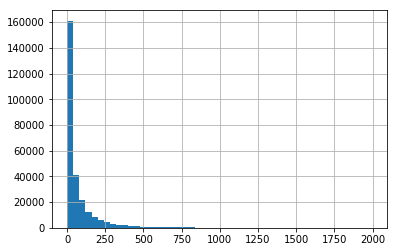

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

df_ratings.groupby('userId')['movieId'].count().hist(bins=50)

Puede observarse que existe un numero significativo de usuarios que han valorado más de 250 películas. Estos responden a un perfil particular y probablemente menos marcado que otros usuarios que hayan votado menos. Esa información siempre es positiva pero, por agilidad, se prescindirá de ellos. Tampoco resultan de utilidad los usuarios que hayan visto pocas películas. 

<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i></font> Eliminar las valoraciones de aquellos usuarios que han votado menos de 5 y más de 200 películas. 

In [10]:
df_ratings = df_ratings.groupby('userId').filter(lambda x: len(x)>5 and len(x)<=200)

df_ratings.shape
# (10127238, 4) 10270063

(10127238, 4)

#### Popularidad

Por último, el archivo `datos/popularity.csv` contiene información sobre la popularidad de cada película. Esta información ha sido obtenida de la base de datos _The Movie Database_ , a la que también se ha recurrido en prácticas anteriores, y se almacenará en el _DataFrame_ `df_popularity`.

In [11]:
df_popularity = pd.read_csv('datos/popularity.csv', index_col=0)
df_popularity.head()

,popularity
movieId,
1,21.946943
2,17.015539
3,11.712900
4,3.859495
5,8.387519


Llegados a este punto, se dispone de 4 _DataFrames_:

* `df_movies`: Con el identificador, título y géneros de cada película.
* `df_genome`: Con el genoma de cada película.
* `df_ratings`: Con las votaciones para cada película. 
* `df_popularity`: Con la popularidad de cada película. 


<div style="text-align: right"> <font size=5> [<i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#990003">](#principio)</i></font></div>

---


## 2. Sistema de recomendación basado en contenido

<br>
La recomendación basada en contenido determina los ítems, películas en este caso, más similares a las mejor valoradas por el usuario; y devuelve un subconjunto de éstas. Aunque existen varias formas para llevar a cabo la implementación, en cada consulta es necesario determinar el conjunto de ítems más cercanos a otro u otros. Puesto que las similaridades/distancias no cambian, es preferible pre-calcularlas y almacenarlas al principio. 


<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i></font>  Calcular las distancias euclídeas entre películas y almacenarlas en una matriz denominada `distances`.   Crear una otra matriz, denominada `ord_similarities`, en la que cada fila represente una película, y contenga los índices de las distancias con el resto, ordenados de menor a mayor. 

<div class="alert alert-block alert-warning">
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
En este caso, el primer elemento de cada fila es el índice de la propia película, ya que la distancia entre cada película consigo misma es cero. Este hecho debe ser tenido en cuenta después. Por otra parte, las dos funciones se pueden implementar en dos líneas. 
</div>

In [12]:
from sklearn.metrics import pairwise_distances

distances = pairwise_distances(df_genome)
ord_similarities = distances.argsort(axis=1)

#### Funciones para el trabajo con dos tablas (es necesario hacerlo y es una situación que nos vamos a encontrar a menudo)

Una vez obtenidas las similaridades, es posible encontrar las películas más similares a otra (u otras) dado su identificador. Sin embargo, es necesario tener en cuenta que los identificadores y las posiciones de las películas en la matriz de distancias no coinciden. Por tanto, para trabajar con la matriz de similaridades, es necesario llevar a cabo las conversiones correspondientes. Aunque no es lo más óptimo, la mejor opción para evitar errores es crear sendas funciones.

<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i></font> Implementar una función, denominada `get_pos_from_ids` que devuelva las posiciones de un conjunto de películas que será representado por un array con sus identificadores.

In [13]:
def get_pos_from_ids(query_ids):
    pos = dict(zip(df_genome.index,range(len(df_genome.index))))
    return [pos[x] for x in query_ids]

query_ids = [1,5765,172547]
query_pos = get_pos_from_ids(query_ids)
query_pos
# array([    0,  5021, 10987])

[0, 5021, 10987]

<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i></font> Implementar una función, denominada `get_ids_from_pos` que, dado un array con las posiciones de un conjunto de películas, devuelva sus identificadores. 

In [14]:
def get_ids_from_pos(query_pos):
    ids = dict(enumerate(df_genome.index))
    return [ids[x] for x in query_pos]
    
query_pos = [0,5021, 10987]
query_ids = get_ids_from_pos(query_pos)
query_ids

#array([     1,   5765, 172547])

[1, 5765, 172547]

### Recuperación de las k películas más similares a  cada película. 

<br>
Una posibilidad a la hora de hacer recomendación basada en contenido consiste en devolver las $k$ películas más similares a las mejor valoradas por el usuario. 

<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i></font> Implementar una función, denominada `get_similar_movies` que tome como argumentos un array denominado `movie_ids`, con los identificadores de una serie de películas, y un entero, `k`, y devuelva las $k$ películas más similares a cada una de las películas en `movie_ids`. El resultado de la funcion ha de ser un array unidimensional en el que __no se repitan__ elementos y en el que ningún `id` esté incluído en `movie_ids`.

In [15]:
def get_most_similar(movie_ids, k):
    pos = get_pos_from_ids(movie_ids)
    pos = np.unique(ord_similarities[pos,1:k+1].flatten())
    ids = get_ids_from_pos(pos)
    ids = np.setdiff1d(ids, movie_ids)
    return ids

query_ids = [1, 5765, 172547]
most_similar_ids = get_most_similar(query_ids, 3)
most_similar_ids
#array([  2354,   2355,   3034,   3114,   4090,   4886,  56176, 104076, 135887])

array([  2354,   2355,   3034,   3114,   4090,   4886,  56176, 104076,
       135887])

<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i></font> Imprimir los nombres de las tres películas de la consulta (`query_ids`) y de las películas similares (`most_similar_ids`). 

In [16]:
print("La películas de la consulta son: ")
display(df_movies.loc[query_ids])

print("\nLa películas similares son: ")
display(df_movies.loc[most_similar_ids])

La películas de la consulta son: 


,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
5765,"Looney, Looney, Looney Bugs Bunny Movie, The (...",Animation|Children|Comedy
172547,Despicable Me 3 (2017),Adventure|Animation|Children|Comedy



La películas similares son: 


,title,genres
movieId,,
2354,"Rugrats Movie, The (1998)",Animation|Children|Comedy
2355,"Bug's Life, A (1998)",Adventure|Animation|Children|Comedy
3034,Robin Hood (1973),Adventure|Animation|Children|Comedy|Musical
3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
4090,"Brave Little Toaster, The (1987)",Animation|Children
4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
56176,Alvin and the Chipmunks (2007),Children|Comedy
104076,"Smurfs 2, The (2013)",Animation|Children|Comedy
135887,Minions (2015),Adventure|Animation|Children|Comedy


<br>

### Recomendación para un usuario

Es posible recomendar a un usuario películas similares a las que mejor ha valorado. En primer lugar, se elegirá un usuario de manera aleatoria. 

In [17]:
np.random.seed(1)
user_id = np.random.choice(df_ratings['userId'].unique(),1)[0]
user_id

160780

Solamente se considerarán de interés aquellas películas valoradas por el usuario de manera positiva. En concreto, solamente aquellas para las que la votación es igual a 5. 

<div class="alert alert-block alert-warning">
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
Obviamente, habría que mejorar esta decisión para considerar usuarios que no tienen películas valoradas con 5, pero no lo haremos en esta práctica porque son detalles secundarios. 
</div>


<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i></font> Implementar una función denominada `get_similar_movies_user` que reciba como argumento el identificador de un usuario, y un parámetro $k$, y devuelva un array con las $k$ películas más parecidas a cada una de las que el usuario ha valorado con 5. Utilizar la función `get_similar_movies`, implementada anteriormente.

In [18]:
def get_sim_movies_user(user_id,k):
    pelis = df_ratings[(df_ratings.rating == 5) & (df_ratings.userId == user_id)].movieId.values
    return get_most_similar(pelis,k)
    
rec = get_sim_movies_user(user_id,5)
print("Películas similares: ", rec.shape[0])

#Películas similares:  37

Películas similares:  37


Como puede verse, el usuario ha votado varias películas, y son muchas las candidatas. Esta recomendación no resulta útil, y debe ser refinada. Una opción consiste en utilizar un menor número de vecinos, o ponderar las veces que aparece cada película entre los vecinos. Sin embargo, pueden seleccionarse las películas que serán recomendadas mediante otro criterio. Por ejemplo, puede usarse la popularidad. 

<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i></font> Implementar una función, denominada `get_recommendation_user_CB` que, dados un usuario y un parámetro $k$, obtenga las películas similares a las valoradas con $5$, ordenadas por popularidad decreciente. Mostrar los títulos de las 10 más populares de entre ellas. 

In [60]:
def get_recommendation_user_CB(user_id,k):
    df_user_rating = df_ratings[(df_ratings.rating == 5) & (df_ratings.userId == user_id)]
    pelis = df_user_rating.movieId.values
    pelis_similares = get_most_similar(pelis,k)
    df_pelis_similares = df_movies.loc[pelis_similares]
    df_pelis_similares['popularity'] = df_popularity.loc[pelis_similares].values
    return df_pelis_similares.sort_values('popularity',ascending=False).index

recommended = get_recommendation_user_CB(user_id,5)[:10]

print("La películas de preferidas por el usuario son: ")
display(df_movies.loc[df_ratings[(df_ratings['userId']==user_id) & (df_ratings['rating']==5)]['movieId']])

print("\nLa películas recomendadas son: ")
display(df_movies.loc[recommended])

La películas de preferidas por el usuario son: 


,title,genres
movieId,,
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
858,"Godfather, The (1972)",Crime|Drama
1206,"Clockwork Orange, A (1971)",Crime|Drama|Sci-Fi|Thriller
1213,Goodfellas (1990),Crime|Drama
1221,"Godfather: Part II, The (1974)",Crime|Drama
2858,American Beauty (1999),Drama|Romance
2959,Fight Club (1999),Action|Crime|Drama|Thriller
3949,Requiem for a Dream (2000),Drama
4262,Scarface (1983),Action|Crime|Drama



La películas recomendadas son: 


,title,genres
movieId,,
122920,Captain America: Civil War (2016),Action|Sci-Fi|Thriller
168252,Logan (2017),Action|Sci-Fi
33794,Batman Begins (2005),Action|Crime|IMAX
128360,The Hateful Eight (2015),Western
1258,"Shining, The (1980)",Horror
778,Trainspotting (1996),Comedy|Crime|Drama
48516,"Departed, The (2006)",Crime|Drama|Thriller
4878,Donnie Darko (2001),Drama|Mystery|Sci-Fi|Thriller
1945,On the Waterfront (1954),Crime|Drama


<div style="text-align: right"> <font size=5> [<i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#990003">](#principio)</i></font></div>

---


## 3. Filtrado colaborativo


<br>
En la propuesta anterior no se han considerado las votaciones del usuario y otros usuarios para llevar a cabo la recomendación. Esta información, no obstante, es útil. La librería `surprise` es una de las más populares para llevar a cabo filtrado colaborativo. En este caso, la utilizaremos para aprender un modelo basado en SVD (parecido al visto en clase). Éste aprende dos matrices que permiten caracterizar usuarios y películas. En este caso, se utilizarán 10 factores. 


<div class="alert alert-block alert-info">
<i class="fa fa-info-circle" aria-hidden="true"></i> El autor principal de la librería describe en una serie de artículos [enlace](http://nicolas-hug.com/blog/) como funciona la versión básica de este algoritmo. La lectura es muy recomendable porque también explica PCA y la relación de SVD con PCA. 
</div>

In [20]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection.split import train_test_split

reader = Reader()
ratings_data = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], reader).build_full_trainset()
svd = SVD(n_factors=10)
svd.fit(ratings_data);

Los modelos en `surprise` cuentan con una función, denominada `svd.predict(uid, iid)` que devuelve el score para un usuario/ítem. En concreto, esta función devuelve una tupla, siendo el elemento con índice 3 el score. 

<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i></font>  Implementar una función, denominada `get_recommendation_user_CF` que, dado un usuario, devuelva las películas __no valoradas todavía__  ordenadas de mejor a peor score. Mostrar 10 películas con mejor score.

In [100]:
def get_recommendation_user_CF(user_id):
    pelis = df_ratings[df_ratings.userId == user_id].movieId.values
    pelis_indices = df_movies.index
    pelis_no_valoradas = set(pelis_indices) - set(pelis)
    df_pelis_no_valoradas = df_movies.loc[pelis_no_valoradas]
    df_pelis_no_valoradas['popularity'] = [svd.predict(user_id,movie_id)[3] for movie_id in pelis_no_valoradas]
    df_pelis_no_valoradas.sort_values('popularity',ascending=False,inplace=True)
    recommended = list(zip(df_pelis_no_valoradas.index,df_pelis_no_valoradas.popularity))
    return recommended

recommendation = get_recommendation_user_CF(user_id)[:10]

for (movie_id, score) in recommendation:
    print("({:.2f})".format(score), df_movies.loc[movie_id]['title'])

(4.20) In the Mood For Love (Fa yeung nin wa) (2000)
(4.20) Once Upon a Time in the West (C'era una volta il West) (1968)
(4.18) Fog of War: Eleven Lessons from the Life of Robert S. McNamara, The (2003)
(4.15) Seven Samurai (Shichinin no samurai) (1954)
(4.15) Three Colors: Blue (Trois couleurs: Bleu) (1993)
(4.14) Down by Law (1986)
(4.13) Lives of Others, The (Das leben der Anderen) (2006)
(4.12) 400 Blows, The (Les quatre cents coups) (1959)
(4.12) Wings of Desire (Himmel über Berlin, Der) (1987)
(4.12) Midnight Cowboy (1969)


<div style="text-align: right"> <font size=5> [<i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#990003">](#principio)</i></font></div>

---


## 4. Sistema híbrido

<br>

Anteriormente se ha implementado un sencillo sistema basado en contenido. En el primero, se devolvía un número muy grande de candidatos, que eran filtrados por popularidad. Es posible utilizar los scores proporcionados por el filtrado colaborativo para filtrar las películas más parecidas a las valoradas positivamente por el usuario, en un enfoque híbrido.

<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i></font> Utilizar el modelo SVD aprendido anteriormente para implementar una función, denominada `get_recommendation_user_HB` que devuelva las películas  similares a las preferidas por el usuario ordenadas por el score obtenido mediante filtrado colaborativo. 

In [136]:
def get_recommendation_user_HB(user_id,k):
    rcmdc_hb = get_recommendation_user_CB(user_id,k)
    df_rcmdc_hb = pd.DataFrame(data=np.zeros(len(rcmdc_hb)),columns=['score'],index=rcmdc_hb)
    df_rcmdc_hb.score = [svd.predict(user_id,movie_id)[3] for movie_id in df_rcmdc_hb.index]
    df_rcmdc_hb.sort_values('score',ascending=False,inplace=True)
    df_rcmdc_hb = df_rcmdc_hb[:10]
    return list(zip(df_rcmdc_hb.index,df_rcmdc_hb.score))
    
recommendations = get_recommendation_user_HB(user_id,5)
recommendations

[(1089, 4.1263954355206991),
 (48516, 4.1034359052969283),
 (27773, 4.0976640451282025),
 (1228, 4.0944103974369943),
 (778, 4.0651440111720269),
 (1258, 4.0588527321837846),
 (4011, 4.0492274849551873),
 (4226, 4.0172945985226391),
 (2542, 4.0069971709412462),
 (4878, 3.9877672996685658)]

<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i></font> Mostrar las 10 películas con mayor score. 

In [137]:
print("\n\nRecomendación: ")
print("----------------------------------")
for (movie_id, score) in recommendations:
    print("({:.2f})".format(score), df_movies.loc[movie_id]['title'])



Recomendación: 
----------------------------------
(4.13) Reservoir Dogs (1992)
(4.10) Departed, The (2006)
(4.10) Old Boy (2003)
(4.09) Raging Bull (1980)
(4.07) Trainspotting (1996)
(4.06) Shining, The (1980)
(4.05) Snatch (2000)
(4.02) Memento (2000)
(4.01) Lock, Stock & Two Smoking Barrels (1998)
(3.99) Donnie Darko (2001)


<div style="text-align: right"> <font size=5> [<i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#990003">](#principio)</i></font></div>

---

<div style="text-align: right"> <font size=6><i class="fa fa-coffee" aria-hidden="true" style="color:#990003"></i> </font></div>

---
<table cellspacing="0" cellpadding="0" border="0">
    <tbody>
        <tr>
            <td rowspan="2">
                <div><img height="317" width="214" alt="io" title="io" style="background-repeat: no-repeat;backgroundposition: 50%;border-radius: 50%;background-size: 100% auto;" src="https://media.licdn.com/dms/image/C4E03AQED9j4Ps-ibhQ/profile-displayphoto-shrink_200_200/0?e=1526270400&v=alpha&t=tAxeQ_DwETWyaBjFOohvti4cvCU4-RWwZjTQN88gG2U" </div>
            </td>
            <td>
                <h1 style="color:#113D68"><span>Héctor Fernando Bahamonde Rivera</span></h1>
                <hr>
                <center><i class="fa fa-envelope" style="color:#113D68"></i></center> 
                <h2><a href="mailto:HectorFernando.Bahamonde@alu.uclm.es" target="_top">HectorFernando.Bahamonde@alu.uclm.es</a></h2>
            </td>
        </tr>
   </tbody>
</table>